---
![title](gdlogo.png)

---

This notebook serves as a thorough example of how to create a parametrized process via the olca ipc API. It includes:
- creating a new (reference flow)
- creating a new (empty) process
- creating a new process input parameter
- creating input and output exchanges, using the parameter embedded in a function as variable input
- creating a product system
- calculating the product system for different parameter redefinitions

This notebook uses the publicly available ELCD 3.2 database (European reference Life Cycle Database, available at: 

In [1]:
from IPython.display import IFrame
IFrame('https://nexus.openlca.org/database/ELCD', width=950, height=500)

# Import

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import olca
import uuid
import math
from datetime import datetime
from itertools import chain

from matplotlib import pyplot as plt

params = {'mathtext.default': 'regular' }

client = olca.Client(8080)
client 

# Example: parametrized process

---
Let's assume, a process for machining steel sections has the following behavior: the **Material Removal Rate, MRR [mm³/s]** has direct influence on the **Specific Energy, SE [J/mm³]** demand of the machining.
The process can be described like this ... or with the function:

$SE = 160 * MRR^{-0.5}$

<AxesSubplot:xlabel='MRR [mm³/s]'>

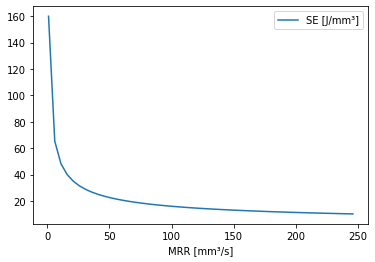

In [3]:
MRR_list = list(range(1, 251, 5))
SE_list = [160 * element**(-0.5) for element in MRR_list]

df_MRR = pd.DataFrame({'MRR [mm³/s]': MRR_list, 'SE [J/mm³]': SE_list })

df_MRR.plot(x='MRR [mm³/s]', y='SE [J/mm³]') 

and the objective is, to build a process, which represents the machining of 50,000 mm³ = 50 cm³ (~ 393,5 g of steel). Therefore, the **Electricity Demand, ED [MJ]** can be expressed with the following formula:

$ED = 8 * MRR^{-0.5}$

In the following, this notebook creates a process, which uses MRR as an input parameter for setting the electricity demand as presented in the formula above.

## Process description
---
The following notebook is intended to  create a process in the active openLCA database with the following characteristics:
(The amount for electricity is a placeholder for now.)

In [4]:
df_process_char = pd.DataFrame({'in/out': ['in', 'in', 'out', 'out'],
                                'flow': ['Steel sections', 'Electricity', 'Steel scrap', 'machined steel section'],
                                'amount':[1, '8*MRR^(-0.5)', 0.3935, 0.6065],
                                'unit': ['kg', 'MJ', 'kg', 'kg'],
                                'ref flow': [False, False, False, True],
                                'provider': ['09d61948-238a-40e7-8e1f-afdc0c98f902', '7e00d0fc-473a-4c90-89e5-0a586010bf31', '11f67def-dc2a-4e74-bb4f-885610a9ae9c', '']
                               })
df_process_char 

,in/out,flow,amount,unit,ref flow,provider
0,in,Steel sections,1,kg,False,09d61948-238a-40e7-8e1f-afdc0c98f902
1,in,Electricity,8*MRR^(-0.5),MJ,False,7e00d0fc-473a-4c90-89e5-0a586010bf31
2,out,Steel scrap,0.3935,kg,False,11f67def-dc2a-4e74-bb4f-885610a9ae9c
3,out,machined steel section,0.6065,kg,True,


----

## Creating a new output flow

In [5]:
dt_object = datetime.fromtimestamp(datetime.timestamp(datetime.now()))


mass = client.find(olca.FlowProperty, 'Mass')

new_flow = olca.product_flow_of('machined steel section', mass)
new_flow.description = 'Added via olca-ipc on %s.' % (dt_object)
client.insert(new_flow) 

'ok'

## Creating a new (empty) process

In [6]:
dt_object = datetime.fromtimestamp(datetime.timestamp(datetime.now()))

new_process = olca.process_of('Machining steel sections, removing 50 cm³ (parametrized)')
new_process.description = 'Added via olca-ipc on %s.' % (dt_object)
client.insert(new_process)

'ok'

## Creating a new parameter

In [7]:
# inserting a new parameter into the process

MRR = olca.parameter_of('MRR', 1, olca.ParameterScope.PROCESS_SCOPE)

new_process.parameters = [MRR]
client.update(new_process) 

'ok'

## Creating input & output exchanges

In [8]:
#finding the flow ids, also for the newly created flow ...

target_refs = []

for index, row in df_process_char.iterrows():
    all_obj = client.get_descriptors(olca.Flow)
    cache = [obj for obj in all_obj if df_process_char['flow'][index] == obj.name]
    target_refs.append(cache)
target_refs = list(chain(*target_refs))    #de-nesting list

target_names = [obj.name for obj in target_refs]
target_ids = [obj.id for obj in target_refs]

flow_df = pd.DataFrame(list(zip(target_names, target_ids)), columns = ['name', 'id'])
#flow_df

#adding flow ids to the original table

df_process_char = pd.concat([df_process_char , flow_df['id']], axis=1)
df_process_char = df_process_char[['in/out', 'flow', 'amount', 'unit', 'ref flow', 'id', 'provider']]
df_process_char

,in/out,flow,amount,unit,ref flow,id,provider
0,in,Steel sections,1,kg,False,f46cd45b-b457-41f3-bd08-1ab41bd796e5,09d61948-238a-40e7-8e1f-afdc0c98f902
1,in,Electricity,8*MRR^(-0.5),MJ,False,890a70b7-b677-4e2a-8a1b-7d017e0a10ae,7e00d0fc-473a-4c90-89e5-0a586010bf31
2,out,Steel scrap,0.3935,kg,False,55a81a3f-4639-4be6-99a0-22586cbc1e84,11f67def-dc2a-4e74-bb4f-885610a9ae9c
3,out,machined steel section,0.6065,kg,True,ee652808-6117-42de-b599-9e9d29ab3449,


In [9]:
#creating a list of exchange objects

list_exchanges = []

for index, row in df_process_char.iterrows():
    cache = client.get(olca.Flow, row['id'])
    
    if row['in/out'] == 'in':
        new_exchange = olca.input_of(new_process, cache, row['amount'])
    elif row['in/out'] == 'out':
        new_exchange = olca.output_of(new_process, cache, row['amount'])
    
    if row['ref flow'] == True:
        new_exchange.quantitative_reference = True
    elif row['ref flow'] == False:
        new_exchange.default_provider = client.get(olca.Process, row['provider'])
        
    list_exchanges.append(new_exchange)

list_exchanges 

In [10]:
# inserting the list of exchanges / updating the new process 

new_process.exchanges = list_exchanges
client.update(new_process) 

'ok'

## Creating a new product system

In [11]:
process_descriptor = client.get_descriptors(olca.Process)
process_list = []
id_list = []

for process in process_descriptor:
    process_list.append(process.name)
    id_list.append(process.id)

processes_df = pd.DataFrame(list(zip(process_list,
                                   id_list)),
                            columns=['name', 'id'])
processes_df

,name,id
0,"Electricity Mix, consumption mix, at consumer, AC, 230-240V",00043bd2-4563-4d73-8df8-b84b5d8902fc
1,"Process steam from natural gas, consumption mix, at plant, heat plant, MJ",00174864-910e-4952-8f02-6ea3a2efa77b
2,"Electricity Mix, consumption mix, at consumer, AC, < 1kV",001b3cb7-b868-4061-8a91-3e6d7bcc90c6
3,"Process steam from Light fuel oil 90%, consumption mix, at power plant, heat plant, MJ, 90 % efficiency",00f9cd63-cba5-4c94-ade3-a4248a9b9dc2
4,"Polyethylene terephthalate (PET) granulate, production mix, at plant, amorphous",028b2915-00a5-4967-b356-34bce19960c3
...,...,...
604,Dummy_Steel scrap (external supply),34f2d06e-8bfe-4af0-bf23-3e01c73bb7b1
605,Dummy_EAF Dust,168babaf-191e-4872-b2ff-d62dc39fff62
606,Dummy_Refractory,00904c02-6e6c-4fe9-a0dd-93fd05dbc018
607,Dummy_Refractory,e0cb4d39-d74d-4f6f-8b82-80ebbe6dea67


In [12]:
product_system = client.create_product_system(processes_df['id'][processes_df.last_valid_index()],
                                              default_providers='prefer',
                                              preferred_type='UNIT_PROCESS')

In [13]:
psID = product_system.id
psID

'00abf302-18bd-4971-90e4-68ed04ac4865'

## Calculation

In [14]:
redef_list = [1,5,25,50,100,150,200,250]

In [15]:
setup = olca.CalculationSetup()
setup.calculation_type = olca.CalculationType.UPSTREAM_ANALYSIS
setup.amount = 0.6065
setup.impact_method = client.find(olca.ImpactMethod, 'IPCC 2013 GWP 100a')
setup.product_system = client.find(olca.ProductSystem, processes_df['name'][processes_df.last_valid_index()])


result_category_list =[]
result_value_list = []
result_unit_list = []

for x in range(len(redef_list)):
    redef = olca.ParameterRedef()
    redef.name = 'MRR'
    redef.context = olca.ref(olca.Process, processes_df['id'][processes_df.last_valid_index()])
    redef.value = redef_list[x]
    setup.parameter_redefs = [redef]
    calc_result = client.calculate(setup)
    gwp = calc_result.impact_results[0].value
    print('MRR is %.2f,\t resulting GWP impact is %.2f kg CO2 eq.' % (redef.value, gwp))
    
    result_category_list.append(calc_result.impact_results[0].impact_category.name)
    result_value_list.append(calc_result.impact_results[0].value)
    result_unit_list.append(calc_result.impact_results[0].impact_category.ref_unit)

    client.dispose(calc_result)
    

MRR is 1.00,	 resulting GWP impact is 8.70 kg CO2 eq.
MRR is 5.00,	 resulting GWP impact is 4.78 kg CO2 eq.
MRR is 25.00,	 resulting GWP impact is 3.02 kg CO2 eq.
MRR is 50.00,	 resulting GWP impact is 2.60 kg CO2 eq.
MRR is 100.00,	 resulting GWP impact is 2.31 kg CO2 eq.
MRR is 150.00,	 resulting GWP impact is 2.18 kg CO2 eq.
MRR is 200.00,	 resulting GWP impact is 2.10 kg CO2 eq.
MRR is 250.00,	 resulting GWP impact is 2.05 kg CO2 eq.


In [16]:
df_results = pd.DataFrame(list(zip(redef_list,
                                   result_category_list,
                                   result_value_list,
                                   result_unit_list)),
                          columns=['MRR [mm³/s]',
                                   'category', 'CC impact [kg CO2e]', 'unit'])
df_results

,MRR [mm³/s],category,CC impact [kg CO2e],unit
0,1,IPCC GWP 100a,8.704251,kg CO2 eq
1,5,IPCC GWP 100a,4.777069,kg CO2 eq
2,25,IPCC GWP 100a,3.020780,kg CO2 eq
3,50,IPCC GWP 100a,2.604617,kg CO2 eq
4,100,IPCC GWP 100a,2.310346,kg CO2 eq
5,150,IPCC GWP 100a,2.179979,kg CO2 eq
6,200,IPCC GWP 100a,2.102265,kg CO2 eq
7,250,IPCC GWP 100a,2.049230,kg CO2 eq


<AxesSubplot:xlabel='MRR [mm³/s]'>

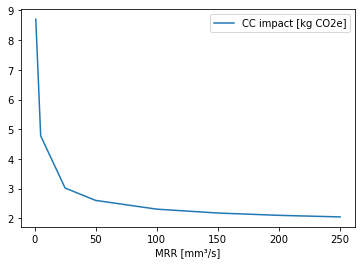

In [17]:
df_final = df_results.drop(['category', 'unit'], axis=1)

df_final.plot(x='MRR [mm³/s]', y='CC impact [kg CO2e]')

# (Optional) deleting unwanted objects

In [ ]:
ps = client.find(olca.ProductSystem, 'Machining steel sections, removing 50 cm³ (parametrized)')
#ps = client.get(olca.ProductSystem, 'fa662a4a-cb29-4475-a684-158d96dba195')
client.delete(ps)

In [ ]:
process = client.find(olca.Process, 'Machining steel sections, removing 50 cm³ (parametrized)')
#process = client.get(olca.Process, 'd6f4fd1d-0386-4d21-a599-af17c7a7cc8d')
client.delete(process)  

In [ ]:
flow = client.find(olca.Flow, 'machined steel section')
#flow = client.get(olca.Flow, '801195e6-4c57-4d36-a7ed-9881b325f891')
client.delete(flow) 